###**Getting Started with torchvision.transforms.v2**


Torchvision supports common computer vision transformations in the torchvision.transforms and torchvision.transforms.v2 modules. Transforms can be used to transform or augment data for training or inference of different tasks (image classification, detection, segmentation, video classification).

Transforms are typically passed as the transform or transforms argument to the Datasets.

We recommending using the torchvision.transforms.v2 transforms instead of those in torchvision.transforms. They’re faster and they can do more things.

In Torchvision 0.15 (March 2023), we released a new set of transforms available in the torchvision.transforms.v2 namespace. These transforms have a lot of advantages compared to the v1 ones (in torchvision.transforms):

They can transform images but also bounding boxes, masks, or videos. This provides support for tasks beyond image classification: detection, segmentation, video classification, etc.

In [ ]:
import torch
from torchvision.transforms import v2
from torchvision.io import read_image

from pathlib import Path
import requests
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = "tight"

torch.manual_seed(1)

In [ ]:
data_dir = Path(".")
# data_dir.mkdir(parents=True, exist_ok=True)
helper_function_path = data_dir / "helpers.py"

if not helper_function_path.is_file():
    print(f"{helper_function_path} not found.. Downloading one")
    with open(helper_function_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/pytorch/vision/main/gallery/transforms/helpers.py")
        f.write(request.content)
else:
    print(f"{helper_function_path} already exists.. Skipping download..")

from helpers import plot

helpers.py not found.. Downloading one


In [ ]:
img_astronaut_path = data_dir / "astronaut.jpg"

if not img_astronaut_path.is_file():
    print(f"{img_astronaut_path} not found.. Downloading one")
    with open(img_astronaut_path, "wb") as f:
        request = requests.get("https://github.com/pytorch/vision/blob/main/gallery/assets/astronaut.jpg?raw=true")
        f.write(request.content)
else:
    print(f"{img_astronaut_path} already exists.. Skipping download..")

astronaut.jpg not found.. Downloading one


In [ ]:
img_astronaut_path

PosixPath('astronaut.jpg')

In [ ]:
my_img = read_image(str(img_astronaut_path))
my_img, my_img.shape

(tensor([[[148, 112,  73,  ..., 125, 125, 125],
          [178, 150, 119,  ..., 125, 125, 125],
          [203, 186, 168,  ..., 125, 125, 125],
          ...,
          [185, 184, 184,  ...,   3,   7,  10],
          [181, 181, 180,  ...,   9,  10,   3],
          [180, 179, 177,  ...,   3,   7,   5]],
 
         [[139, 103,  65,  ..., 116, 116, 116],
          [169, 141, 111,  ..., 116, 116, 116],
          [195, 178, 160,  ..., 116, 116, 116],
          ...,
          [170, 169, 167,  ...,   0,   3,   6],
          [168, 169, 165,  ...,   5,   6,   0],
          [167, 167, 162,  ...,   0,   3,   1]],
 
         [[158, 120,  80,  ..., 111, 111, 111],
          [186, 158, 124,  ..., 111, 111, 111],
          [210, 191, 171,  ..., 111, 111, 111],
          ...,
          [177, 174, 173,  ...,   0,   0,   3],
          [175, 173, 170,  ...,   2,   3,   0],
          [174, 171, 167,  ...,   0,   0,   0]]], dtype=torch.uint8),
 torch.Size([3, 512, 512]))

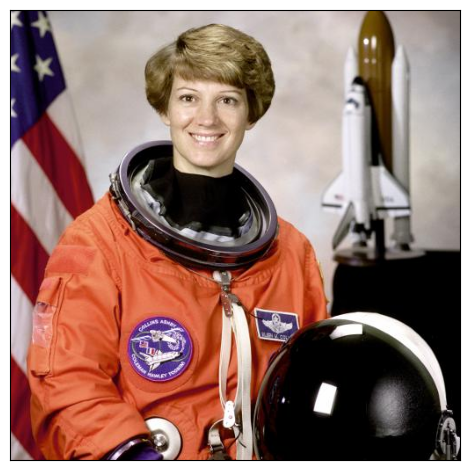

In [ ]:
plot([my_img])

In [ ]:
#apply RandomCrop transform from v2
transform_resize = v2.Compose([
    v2.RandomCrop((224, 224))
])
transformed_img = transform_resize(my_img)
transformed_img.shape

torch.Size([3, 224, 224])

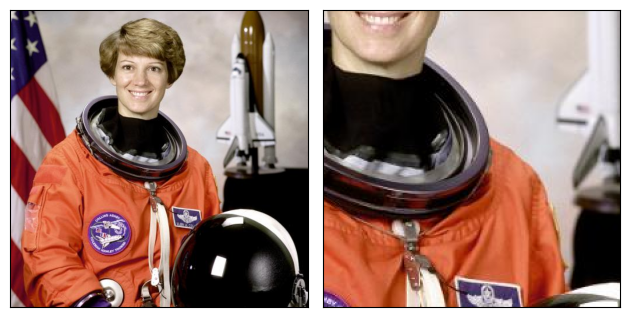

In [ ]:
plot([my_img, transformed_img])

f you just care about image classification, things are very simple. A basic classification pipeline may look like this:

In [ ]:
transforms = v2.Compose([
    v2.RandomResizedCrop((224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #https://pytorch.org/vision/main/generated/torchvision.transforms.v2.Normalize.html
])
transformed_img = transforms(my_img)

In [ ]:
my_img.dtype, transformed_img.dtype

(torch.uint8, torch.float32)

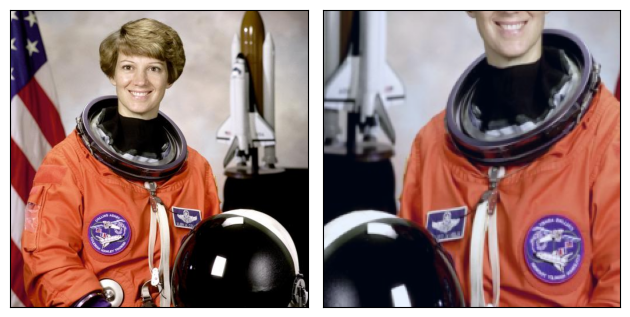

In [ ]:
plot([my_img, transformed_img])

Note: Such transformation pipeline is typically passed as the transform argument to the Datasets, e.g. ImageNet(..., transform=transforms).

###**Detection, Segmentation, Videos with tv_tensors**
The new Torchvision transforms in the torchvision.transforms.v2 namespace support tasks beyond image classification: they can also transform bounding boxes, segmentation / detection masks, or videos.

Let’s briefly look at a detection example with bounding boxes.

In [ ]:
my_img.shape[-2:]

torch.Size([512, 512])

In [ ]:
from torchvision import tv_tensors

#boxes on original image
boxes = tv_tensors.BoundingBoxes([
    [15, 10, 370, 510],
    [275, 340, 510, 510],
    [130, 345, 210, 425]], format="XYXY", canvas_size=my_img.shape[-2:])

transforms = v2.Compose([
    v2.RandomResizedCrop((224, 224), antialias=True),
    v2.RandomPhotometricDistort(p=1),
    v2.RandomHorizontalFlip(p=1)
])

transformed_img, trasformed_boxes = transforms(my_img, boxes)

print(my_img.shape, transformed_img.shape)
print(type(boxes), "\n", type(trasformed_boxes))
print(boxes, "\n", trasformed_boxes)

torch.Size([3, 512, 512]) torch.Size([3, 224, 224])
<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> 
 <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>
BoundingBoxes([[ 15,  10, 370, 510],
               [275, 340, 510, 510],
               [130, 345, 210, 425]], format=BoundingBoxFormat.XYXY, canvas_size=torch.Size([512, 512])) 
 BoundingBoxes([[ 63,   0, 224, 224],
               [  0, 146, 110, 224],
               [141, 148, 180, 189]], format=BoundingBoxFormat.XYXY, canvas_size=(224, 224))


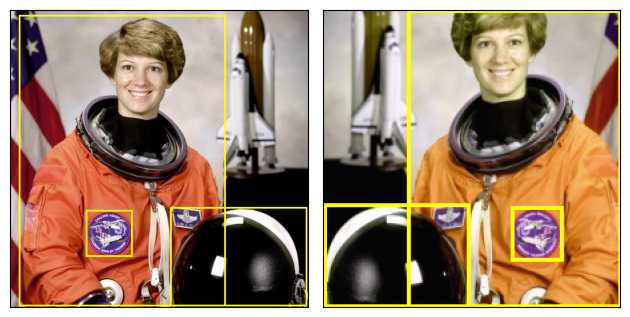

In [ ]:
plot([(my_img, boxes), (transformed_img, trasformed_boxes)])

The example above focuses on object detection. But if we had masks (torchvision.tv_tensors.Mask) for object segmentation or semantic segmentation, or videos (torchvision.tv_tensors.Video), we could have passed them to the transforms in exactly the same way.

###**What do I pass as input to transforms?**
Above, we’ve seen two examples: one where we passed a single image as input i.e.``` out = transforms(img)```, and one where we passed both an image and bounding boxes, i.e. ```out_img, out_boxes = transforms(img, boxes)```.

In fact, transforms support arbitrary input structures. The input can be a single image, a tuple, an arbitrarily nested dictionary… pretty much anything. The same structure will be returned as output. Below, we use the same detection transforms, but pass a tuple (image, target_dict) as input and we’re getting the same structure as output:

In [ ]:
boxes.shape

torch.Size([3, 4])

('arbitrary', {'structure': '!'})


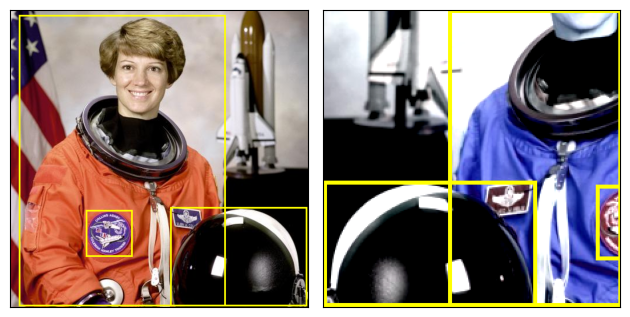

In [ ]:
target = {
    "boxes": boxes,
    "box_labels": torch.arange(boxes.shape[0]),
    "this_is_ignored":("arbitrary", {"structure": "!"})}
out_img, out_target = transforms(my_img, target)

plot([(my_img, target["boxes"]), (out_img, out_target["boxes"])])
print(f"{out_target['this_is_ignored']}")

We passed a tuple so we get a tuple back, and the second element is the tranformed target dict. Transforms don’t really care about the structure of the input; as mentioned above, they only care about the type of the objects and transforms them accordingly.

Foreign objects like strings or ints are simply passed-through. This can be useful e.g. if you want to associate a path with every single sample when debugging!

By now you likely have a few questions: what are these TVTensors, how do we use them, and what is the expected input/output of those transforms?

###**What are TVTensors?**
TVTensors are torch.Tensor subclasses. The available TVTensors are Image, BoundingBoxes, Mask, and Video.

TVTensors look and feel just like regular tensors - they are tensors. Everything that is supported on a plain torch.Tensor like .sum() or any torch.* operator will also work on a TVTensor:

In [ ]:
img_dp = tv_tensors.Image(torch.randint(0, 256, size=(3, 256, 256), dtype=torch.uint8))
img_dp, img_dp.shape, img_dp.dtype, img_dp.sum()

(Image([[[233, 137,   7,  ...,  50,  79, 169],
         [ 64, 108, 211,  ..., 233, 237, 232],
         [234,  11, 150,  ...,  43, 147,  79],
         ...,
         [243,  28, 196,  ..., 131,  42,   0],
         [154, 124, 139,  ..., 164,  22, 142],
         [ 30,  77, 160,  ..., 242, 118, 110]],
 
        [[209,  94, 116,  ...,  69,  75, 217],
         [ 14,  38, 172,  ...,  87,  90,  35],
         [159, 140, 211,  ...,  61,  15, 170],
         ...,
         [142,  40, 205,  ..., 245,  72, 162],
         [159, 199, 153,  ..., 250, 152, 124],
         [127,  91, 210,  ..., 241,  43, 159]],
 
        [[164,  45, 107,  ..., 110,   8, 155],
         [ 12, 195, 235,  ..., 104, 181,  34],
         [ 66, 107, 129,  ..., 168, 250, 189],
         ...,
         [186,  55,  37,  ...,  23, 185, 125],
         [ 68, 187,  30,  ..., 230, 171,  43],
         [166, 198,  73,  ..., 239, 174, 123]]], dtype=torch.uint8, ),
 torch.Size([3, 256, 256]),
 torch.uint8,
 tensor(25087388))

###**Transforms and Datasets intercompatibility**
Roughly speaking, the output of the datasets must correspond to the input of the transforms. How to do that depends on whether you’re using the torchvision built-in datatsets, or your own custom datasets.

Using built-in datasets
If you’re just doing image classification, you don’t need to do anything. Just use transform argument of the dataset e.g. ImageNet(..., transform=transforms) and you’re good to go.

Torchvision also supports datasets for object detection or segmentation like ```torchvision.datasets.CocoDetection```. Those datasets predate the existence of the ```torchvision.transforms.v2``` module and of the ```TVTensors```, so they don’t return TVTensors out of the box.

An easy way to force those datasets to return TVTensors and to make them compatible with v2 transforms is to use the ```torchvision.datasets.wrap_dataset_for_transforms_v2()``` function:

In [ ]:
# from torchvision.datasets import CocoDetection, wrap_dataset_for_transforms_v2
# dataset = CocoDetection(root="./", annFile="", transform=transforms)
# dataset = wrap_dataset_for_transforms_v2(dataset)
# # Now the dataset returns TVTensors!

###**Using your own datasets and conversion to TVTensors**
If you have a custom dataset, then you’ll need to convert your objects into the appropriate TVTensor classes. Creating TVTensor instances is very easy, refer to How do I construct a TVTensor? for more details https://pytorch.org/vision/stable/auto_examples/transforms/plot_tv_tensors.html#tv-tensor-creation.

There are two main places where you can implement that conversion logic:

- At the end of the datasets’s __getitem__ method, before returning the sample (or by sub-classing the dataset).

- As the very first step of your transforms pipeline

Either way, the logic will depend on your specific dataset.

###**Illustration of different kinds of Transforms**
- Geometric Transforms
    - Pad
    - Resize
    - CenterCrop
    - FiveCrop
    - RandomPerspective
    - RandomRotation
    - RandomAffine
    - ElasticTransform
    - RandomCrop
    - RandomResizedCrop
- Photometric Transforms
    - Grayscale
    - ColorJitter
    - GaussianBlur
    - RandomInvert
    - RandomPosterize
    - RandomSolarize
    - RandomAdjustSharpness
    - RandomAutocontrast
    - RandomEqualize
- Augmentation Transforms
    - AutoAugment
    - RandAugment
    - TrivialAugmentWide
    - AugMix
- Randomly-applied Transforms
    - RandomHorizontalFlip
    - RandomVerticalFlip
    - RandomApply

###**Geometric Transforms**

Geometric image transformation refers to the process of altering the geometric properties of an image, such as its shape, size, orientation, or position. It involves applying mathematical operations to the image pixels or coordinates to achieve the desired transformation.

####**Pad**

In [ ]:
my_img = read_image(str(img_astronaut_path))
my_img, my_img.shape, my_img.size()

(tensor([[[148, 112,  73,  ..., 125, 125, 125],
          [178, 150, 119,  ..., 125, 125, 125],
          [203, 186, 168,  ..., 125, 125, 125],
          ...,
          [185, 184, 184,  ...,   3,   7,  10],
          [181, 181, 180,  ...,   9,  10,   3],
          [180, 179, 177,  ...,   3,   7,   5]],
 
         [[139, 103,  65,  ..., 116, 116, 116],
          [169, 141, 111,  ..., 116, 116, 116],
          [195, 178, 160,  ..., 116, 116, 116],
          ...,
          [170, 169, 167,  ...,   0,   3,   6],
          [168, 169, 165,  ...,   5,   6,   0],
          [167, 167, 162,  ...,   0,   3,   1]],
 
         [[158, 120,  80,  ..., 111, 111, 111],
          [186, 158, 124,  ..., 111, 111, 111],
          [210, 191, 171,  ..., 111, 111, 111],
          ...,
          [177, 174, 173,  ...,   0,   0,   3],
          [175, 173, 170,  ...,   2,   3,   0],
          [174, 171, 167,  ...,   0,   0,   0]]], dtype=torch.uint8),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]))

In [ ]:
padded_images = [v2.Pad(padding=pad)(my_img) for pad in (3, 10, 30, 50)] #applying different pads to the img

In [ ]:
len(padded_images), my_img.shape, padded_images[0].shape, padded_images[1].shape, padded_images[2].shape, padded_images[3].shape

(4,
 torch.Size([3, 512, 512]),
 torch.Size([3, 518, 518]),
 torch.Size([3, 532, 532]),
 torch.Size([3, 572, 572]),
 torch.Size([3, 612, 612]))

In [ ]:
len([my_img] + padded_images)

5

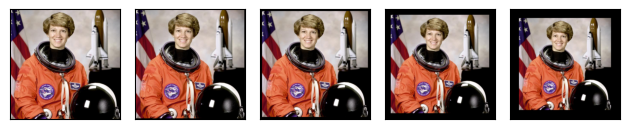

In [ ]:
plot([my_img] + padded_images)

####**Resize**
The Resize transform (see also resize()) resizes an image.

In [ ]:
my_img.size(), my_img.shape

(torch.Size([3, 512, 512]), torch.Size([3, 512, 512]))

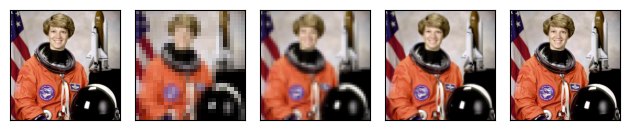

In [ ]:
resized_imgs = [v2.Resize(size=size, antialias=True)(my_img) for size in (30, 50, 100, my_img.shape[-1:])]
plot([my_img] + resized_imgs)

In [ ]:
my_img.shape, resized_imgs[0].shape, resized_imgs[1].shape, resized_imgs[2].shape, resized_imgs[3].shape

(torch.Size([3, 512, 512]),
 torch.Size([3, 30, 30]),
 torch.Size([3, 50, 50]),
 torch.Size([3, 100, 100]),
 torch.Size([3, 512, 512]))

####**CenterCrop**
The CenterCrop transform (see also center_crop() from torchvision.transforms.functional.center_crop) crops the given image at the center.

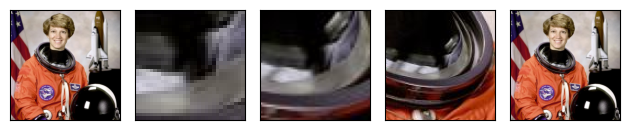

In [ ]:
centercropped_imgs = [v2.CenterCrop(size=size)(my_img) for size in (30, 50 , 100, my_img.shape[-1])]
plot([my_img] + centercropped_imgs)

In [ ]:
my_img.shape, centercropped_imgs[0].shape, centercropped_imgs[1].shape, centercropped_imgs[2].shape, centercropped_imgs[3].shape

(torch.Size([3, 512, 512]),
 torch.Size([3, 30, 30]),
 torch.Size([3, 50, 50]),
 torch.Size([3, 100, 100]),
 torch.Size([3, 512, 512]))

####**FiveCrop**
The FiveCrop transform (see also five_crop() - torchvision.transforms.functional.five_crop()) crops the given image into four corners and the central crop.

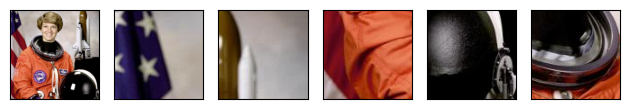

In [ ]:
(top_left, top_right, bottom_left, bottom_right, center) = v2.FiveCrop(size=(100, 100))(my_img)
plot([my_img] + [top_left, top_right, bottom_left, bottom_right, center])

####**RandomPerspective**
The RandomPerspective transform (see also perspective() - torchvision.transforms.functional.perspective() performs random perspective transform on an image.

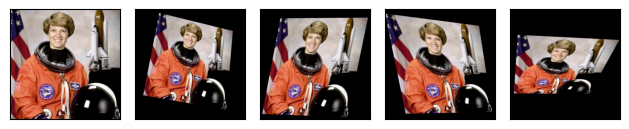

In [ ]:
perspective_transformer = v2.RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_imgs = [perspective_transformer(my_img) for _ in range(4)]
plot([my_img] + perspective_imgs)

In [ ]:
my_img.shape, perspective_imgs[0].shape, perspective_imgs[1].shape, perspective_imgs[2].shape, perspective_imgs[3].shape

(torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]))

####**RandomRotation**
The RandomRotation transform (see also torchvision.transforms.functional.rotate()) rotates an image with random angle.

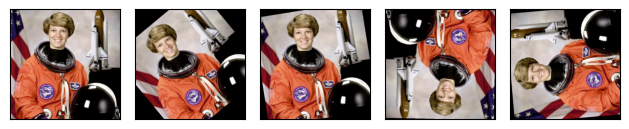

In [ ]:
rotater = v2.RandomRotation(degrees=(0, 180))
rotated_imgs = [rotater(my_img) for _ in range(4)]
plot([my_img] + rotated_imgs)

In [ ]:
my_img.shape, rotated_imgs[0].shape, rotated_imgs[1].shape, rotated_imgs[2].shape, rotated_imgs[3].shape

(torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]))

####**RandomAffine**
The RandomAffine transform (see also torchvision.transforms.functional.affine()) performs random affine transform on an image.

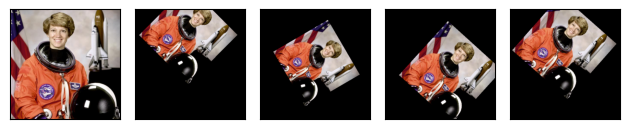

In [ ]:
affine_transform = v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))
affine_imgs = [affine_transform(my_img) for _ in range(4)]
plot([my_img] + affine_imgs)

In [ ]:
my_img.shape, affine_imgs[0].shape, affine_imgs[1].shape, affine_imgs[2].shape, affine_imgs[3].shape

(torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]))

####**ElasticTransform**
The ElasticTransform transform (see also torchvision.transforms.functional.elastic_transform()) Randomly transforms the morphology of objects in images and produces a see-through-water-like effect.

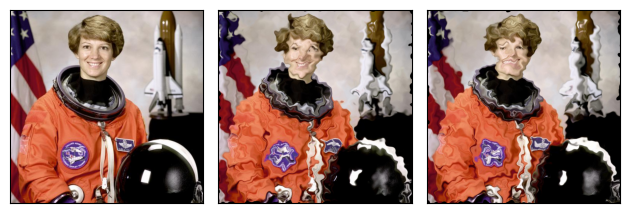

In [ ]:
elastic_transform = v2.ElasticTransform(alpha=250.0)
elastic_imgs = [elastic_transform(my_img) for _ in range(2)]
plot([my_img] + elastic_imgs)

####**RandomCrop**
The RandomCrop transform (see also  torchvision.transforms.functional.crop()) crops an image at a random location.

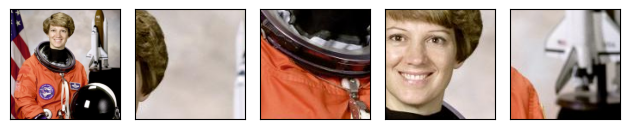

In [ ]:
randomcrop_transform = v2.RandomCrop(size=(128, 128))
randomcrop_imgs = [randomcrop_transform(my_img) for _ in range(4)]
plot([my_img] + randomcrop_imgs)

####**RandomResizedCrop**
The RandomResizedCrop transform (see also torchvision.transforms.functional.resized_crop()) crops an image at a random location, and then resizes the crop to a given size.

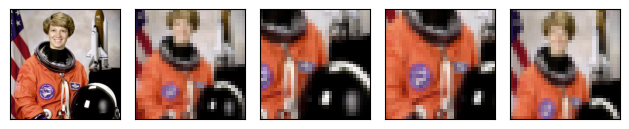

In [ ]:
randomresizecrop_transform = v2.RandomResizedCrop(size=(32, 32), antialias=True)
randomresizecrop_imgs = [randomresizecrop_transform(my_img) for _ in range(4)]
plot([my_img] + randomresizecrop_imgs)

In [ ]:
my_img.shape, randomresizecrop_imgs[0].shape, randomresizecrop_imgs[1].shape, randomresizecrop_imgs[2].shape, randomresizecrop_imgs[3].shape

(torch.Size([3, 512, 512]),
 torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]))

###**Photometric Transforms**
Photometric image transformation refers to the process of modifying the photometric properties of an image, such as its brightness, contrast, color, or tone. These transformations are applied to change the visual appearance of an image while preserving its geometric structure.

Except Grayscale, the following transforms are random, which means that the same transform instance will produce different result each time it transforms a given image.



####**Grayscale**
The Grayscale transform (see also torchvision.transforms.functional.to_grayscale()) converts an image to grayscale



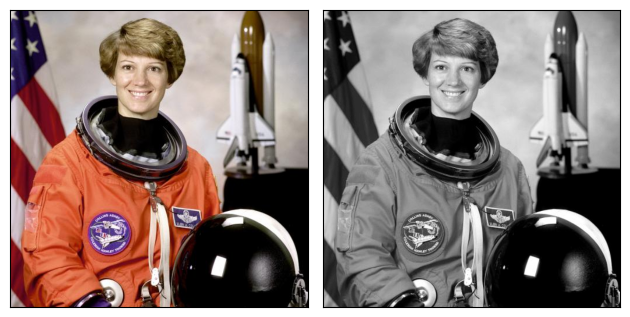

In [ ]:
gray_img = v2.Grayscale()(my_img)
plot([my_img, gray_img], cmap='gray')

####**ColorJitter**
The ColorJitter transform randomly changes the brightness, contrast, saturation, hue, and other properties of an image.

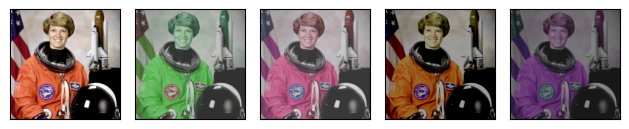

In [ ]:
jitter_transform = v2.ColorJitter(brightness=0.5, contrast=0.8, saturation=0.1, hue=0.3)
jittered_imgs = [jitter_transform(my_img) for _ in range(4)]
plot([my_img] + jittered_imgs)

####**GaussianBlur**
The GaussianBlur transform (see also gaussian_blur()) performs gaussian blur transform on an image.

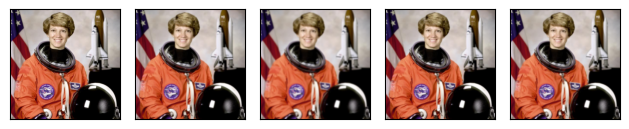

In [ ]:
guassianblur_transform = v2.GaussianBlur(kernel_size=(11, 9), sigma=(0.1, 5.0))
guasblur_imgs = [guassianblur_transform(my_img) for _ in range(4)]
plot([my_img] + guasblur_imgs)

####**RandomInvert**
The RandomInvert transform (see also invert()) randomly inverts the colors of the given image.

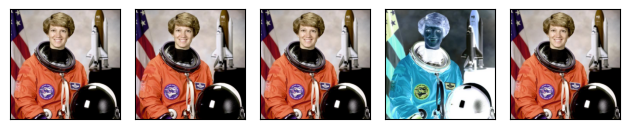

In [ ]:
inverter = v2.RandomInvert(p=0.5)
invertered_imgs = [inverter(my_img) for _ in range(4)]
plot([my_img] + invertered_imgs)

In [ ]:
my_img.shape, invertered_imgs[0].shape, invertered_imgs[1].shape, invertered_imgs[2].shape, invertered_imgs[3].shape

(torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]))

####**RandomPosterize**
The RandomPosterize transform (see also posterize()) randomly posterizes the image by reducing the number of bits of each color channel.

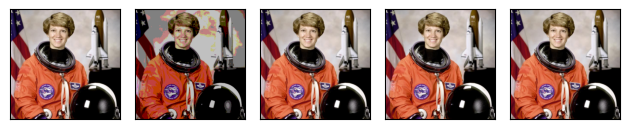

In [ ]:
posterizer = v2.RandomPosterize(bits=2, p=0.5)
posterized_imgs = [posterizer(my_img) for _ in range(4)]
plot([my_img] + posterized_imgs)

####**RandomSolarize**
The RandomSolarize transform (see also solarize()) randomly solarizes the image by inverting all pixel values above the threshold

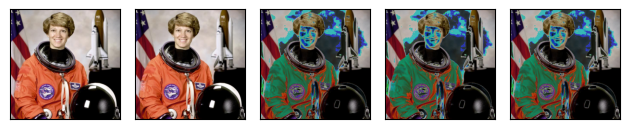

In [ ]:
solarizer = v2.RandomSolarize(threshold=192.0, p=0.5)
solarized_imgs = [solarizer(my_img) for _ in range(4)]
plot([my_img] + solarized_imgs)

####**RandomAdjustSharpness**
The RandomAdjustSharpness transform (see also adjust_sharpness()) randomly adjusts the sharpness of the given image.

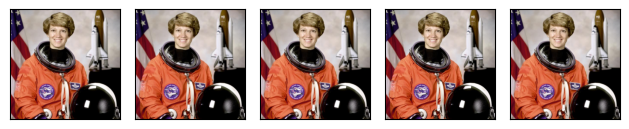

In [ ]:
sharpness_adjuster = v2.RandomAdjustSharpness(sharpness_factor=2, p=0.5)
sharpened_imgs = [sharpness_adjuster(my_img) for _ in range(4)]
plot([my_img] + sharpened_imgs)

####**RandomAutocontrast**
The RandomAutocontrast transform (see also autocontrast()) randomly applies autocontrast to the given image.

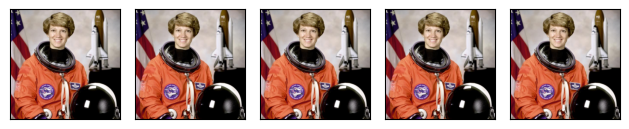

In [ ]:
autocontraster = v2.RandomAutocontrast(p=0.5)
autocontrasted_imgs = [autocontraster(my_img) for _ in range(4)]
plot([my_img] + autocontrasted_imgs)

####**RandomEqualize**
The RandomEqualize transform (see also equalize()) randomly equalizes the histogram(color histogram) of the given image.

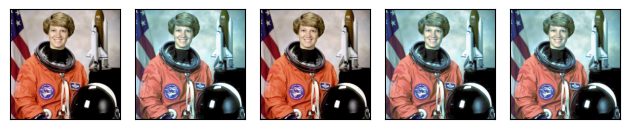

In [ ]:
equalizer = v2.RandomEqualize(p=0.5)
equalized_imgs = [equalizer(my_img) for _ in range(4)]
plot([my_img] + equalized_imgs)

###**Augmentation Transforms**
The following transforms are combinations of multiple transforms, either geometric or photometric, or both.

####**AutoAugment**
The AutoAugment transform automatically augments data based on a given auto-augmentation policy. See AutoAugmentPolicy https://pytorch.org/vision/stable/generated/torchvision.transforms.AutoAugmentPolicy.html#torchvision.transforms.AutoAugmentPolicy for the available policies.

AutoAugment policies learned on different datasets. Available policies are IMAGENET, CIFAR10 and SVHN.

[AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10), AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.IMAGENET), AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.SVHN)]
3


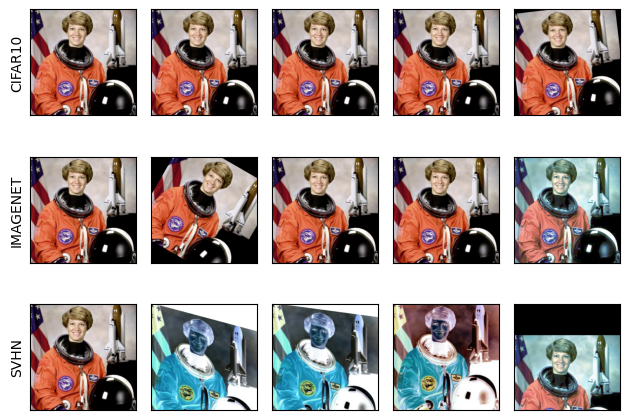

In [ ]:
policies = [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
augmenters = [v2.AutoAugment(policy) for policy in policies]
print(augmenters)

augmented_imgs = [[augmenter(my_img) for _ in range(4)] for augmenter in augmenters]
print(len(augmented_imgs))

row_name = [str(policy).split(".")[-1] for policy in policies]
plot([[my_img] + row_img for row_img in augmented_imgs], row_title=row_name)

####**RandAugment**
The RandAugment is an alternate version of AutoAugment.

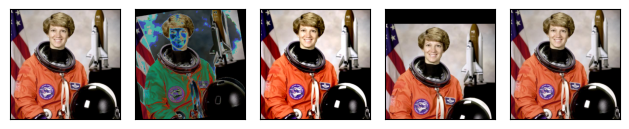

In [ ]:
randaug = v2.RandAugment()
randaugimgs = [randaug(my_img) for _ in range(4)]
plot([my_img] + randaugimgs)

####**TrivialAugmentWide**
The TrivialAugmentWide is an alternate implementation of AutoAugment. However, instead of transforming an image multiple times, it transforms an image only once using a random transform from a given list with a random strength number.

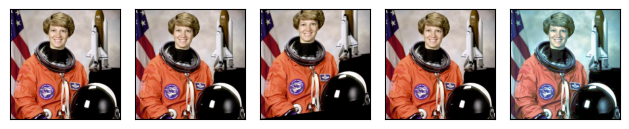

In [ ]:
trivialaugmenter = v2.TrivialAugmentWide()
trivialaugmentedimgs = [trivialaugmenter(my_img) for _ in range(4)]
plot([my_img] + trivialaugmentedimgs)

####**AugMix**
The AugMix transform interpolates between augmented versions of an image.

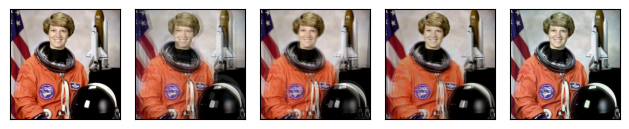

In [ ]:
augmix = v2.AugMix()
augmix_imgs = [augmix(my_img) for _ in range(4)]
plot([my_img] + augmix_imgs)

###**Randomly-applied Transforms**
The following transforms are randomly-applied given a probability p. That is, given p = 0.5, there is a 50% chance to return the original image, and a 50% chance to return the transformed image, even when called with the same transform instance!

####**RandomHorizontalFlip**
The RandomHorizontalFlip transform (see also hflip()) performs horizontal flip of an image, with a given probability.

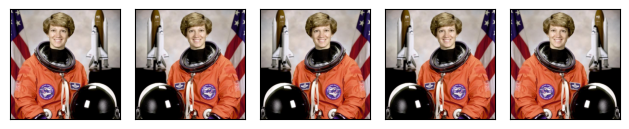

In [ ]:
hflipper = v2.RandomHorizontalFlip(p=0.5)
htransformed_imgs = [hflipper(my_img) for _ in range(4)]
plot([my_img] + htransformed_imgs)

####**RandomVerticalFlip**
The RandomVerticalFlip transform (see also vflip()) performs vertical flip of an image, with a given probability.

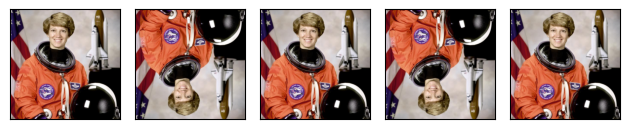

In [ ]:
vflipper = v2.RandomVerticalFlip(p=0.5)
vtransformed_imgs = [vflipper(my_img) for _ in range(4)]
plot([my_img] + vtransformed_imgs)

####**RandomApply**
The RandomApply transform randomly applies a list of transforms, with a given probability.

In [ ]:
my_img.shape

torch.Size([3, 512, 512])

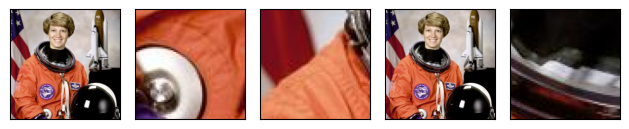

In [ ]:
randomapplier = v2.RandomApply(transforms=[v2.RandomCrop((64, 64))], p=0.5)
randomly_transformed_imgs = [randomapplier(my_img) for _ in range(4)]
plot([my_img] + randomly_transformed_imgs)

###**CutMix and MixUp**
CutMix and MixUp are popular augmentation strategies that can improve classification accuracy.

These transforms are slightly different from the rest of the Torchvision transforms, because they expect batches of samples as input, not individual images. In this example we’ll explain how to use them: after the DataLoader, or as part of a collation function.

In [113]:
import torch
from torchvision.datasets import FakeData
from torchvision.transforms import v2

NUM_CLASSES = 100

#Pre-processing pipeline

preproc = v2.Compose([
    v2.PILToTensor(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),  # to float32 in [0, 1]
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # typically from ImageNet
])

dataset = FakeData(size=1000,
                   image_size=(3, 224, 224),
                   num_classes=NUM_CLASSES,
                   transform=preproc)

dataset

Dataset FakeData
    Number of datapoints: 1000
    StandardTransform
Transform: Compose(
                 PILToTensor()
                 RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToDtype(scale=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

In [115]:
img, label = dataset[0]
img.shape, label

(torch.Size([3, 224, 224]), 67)

In [116]:
dataset.num_classes

100

One important thing to note is that neither CutMix nor MixUp are part of this pre-processing pipeline. We’ll add them a bit later once we define the DataLoader. Just as a refresher, this is what the DataLoader and training loop would look like if we weren’t using CutMix or MixUp:

```
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

for images, labels in dataloader:
    print(f"{images.shape = }, {labels.shape = }")
    print(labels.dtype)
    # <rest of the training loop here>
    break
```

In [117]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

for images, labels in dataloader:
    print(f"{images.shape = }, {labels.shape = }")
    print(labels.dtype)
    # <rest of the training loop here>
    break

images.shape = torch.Size([4, 3, 224, 224]), labels.shape = torch.Size([4])
torch.int64


####**Where to use MixUp and CutMix? - After the DataLoader**

Now let’s add CutMix and MixUp. The simplest way to do this right after the DataLoader: the Dataloader has already batched the images and labels for us, and this is exactly what these 2 transforms expect as input:

In [118]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
cutmix = v2.CutMix(num_classes=NUM_CLASSES)
mixup = v2.MixUp(num_classes=NUM_CLASSES)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

for batch, (imgs, labels) in enumerate(dataloader):
    print(f"Before CutMix/MixUp: {images.shape = }, {labels.shape = }")
    imgs, labels = cutmix_or_mixup(imgs, labels)
    print(f"After CutMix/MixUp: {images.shape = }, {labels.shape = }")
    break


Before CutMix/MixUp: images.shape = torch.Size([4, 3, 224, 224]), labels.shape = torch.Size([4])
After CutMix/MixUp: images.shape = torch.Size([4, 3, 224, 224]), labels.shape = torch.Size([4, 100])


Note how the labels were also transformed: we went from a batched label of shape (batch_size,) to a tensor of shape (batch_size, num_classes). The transformed labels can still be passed as-is to a loss function like torch.nn.functional.cross_entropy().

####**As part of the collation function**
Passing the transforms after the DataLoader is the simplest way to use CutMix and MixUp, but one disadvantage is that it does not take advantage of the DataLoader multi-processing. For that, we can pass those transforms as part of the collation function (refer to the PyTorch docs to learn more about collation).

In [119]:
from torch.utils.data import DataLoader
from torch.utils.data import default_collate

def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)

for images, labels in dataloader:
    print(f"{images.shape = }, {labels.shape = }")
    # No need to call cutmix_or_mixup, it's already been called as part of the DataLoader!
    # <rest of the training loop here>
    break

images.shape = torch.Size([4, 3, 224, 224]), labels.shape = torch.Size([4, 100])


####**Non-standard input format**
So far we’ve used a typical sample structure where we pass (images, labels) as inputs. MixUp and CutMix will magically work by default with most common sample structures: tuples where the second parameter is a tensor label, or dict with a “label[s]” key. Look at the documentation of the labels_getter parameter for more details.

If your samples have a different structure, you can still use CutMix and MixUp by passing a callable to the labels_getter parameter. For example:

In [120]:
batch = {
    "imgs": torch.rand(4, 3, 224, 224),
    "target": {
        "classes": torch.randint(0, NUM_CLASSES, size=(4,)),
        "some_other_key": "this is going to be passed-through"
    }
}

def labels_getter(batch):
    return batch["target"]["classes"]

out = v2.CutMix(num_classes=NUM_CLASSES, labels_getter=labels_getter)(batch)
print(f"{out['imgs'].shape = }, {out['target']['classes'].shape = }")

out['imgs'].shape = torch.Size([4, 3, 224, 224]), out['target']['classes'].shape = torch.Size([4, 100])
